In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.utils as vutils
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

import numpy as np

import sys
base = "../../"
sys.path.append(base + "models")
from vqgan.vqgan import VQGAN
from vqgan.discriminator import Discriminator
from vqgan.perceptual_loss import LPIPS
sys.path.append(base + "datasets")
from pokedata import PokemonDataset

C:\Users\canof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
batch_size = 128    # batch size
epochs = 50

# image 
im_size = 96        # input image h & w
im_c = 3            # number of color channels
# gan params
nz = 8              # latent dimension size, 16 used in literature, let's start with 8 and maybe go to 16
nz_c = 8            # total dimensions per vector in latent space
d_patches = 8       # h and w for patchgan discriminator output
nef = 64            # encoder feature maps
ngf = 64            # generator feature maps
ndf = 64            # discriminator feature maps
disc_factor = 1.    # scaling factor for discriminator loss 
disc_start = 10000  # when to start training discriminator


# transformer params
sequence_length = nz ** 2
codebook_size = 512 # 8192 used in larger visual models, maybe try pushing up to 1024 or looking at 256?
beta = 0.25 # used for codebook

# loss params
lda = 100

# training params
lr=2e-5
beta1=0.5 # Adam params
beta2=0.9

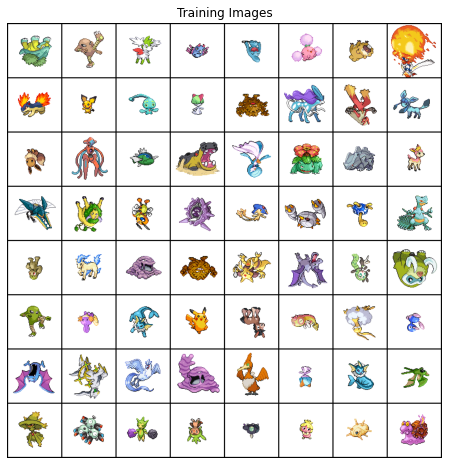

In [3]:
# load dataset
data_path = "../../data"
csv_path = data_path + "/data.csv"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                # transforms.ColorJitter(brightness=0.1, hue=0.1, 
                                #                        contrast=0.1, saturation=0.1),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# load data
dataset = PokemonDataset(csv_file=csv_path, root_dir=data_path, transform=transform, get_types=True)

dataloader = DataLoader(dataset, batch_size=batch_size, 
                          shuffle=True)

# pick data device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
im_batch = real_batch[0][:64].detach()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

In [4]:
# ad hoc testing of G's components E+D
from vqgan.generator import Encoder, Generator

netE = Encoder()
netG = Generator()

netD = Discriminator()

x = torch.randn(128, 3, 96, 96)
z = netE(x)
x_hat = netG(z)

l = netD(x)

x.shape, z.shape, x_hat.shape, l.shape


(torch.Size([128, 3, 96, 96]),
 torch.Size([128, 8, 8, 8]),
 torch.Size([128, 3, 96, 96]),
 torch.Size([128, 1, 6, 6]))

In [5]:
# attempt at writing a VQGAN training function
model_g = VQGAN(codebook_size=codebook_size, latent_dim=nz_c, beta=beta).to(device)
model_d = Discriminator().to(device)

p_loss = LPIPS(pt_path="../../pretrained_models/ploss.pt").to(device)
criterion = nn.BCELoss()


g_optim = torch.optim.Adam(
    model_g.parameters(),
    lr=lr, eps=1e-08, betas=(beta1, beta2)
)

d_optim = torch.optim.Adam(
    model_d.parameters(),
    lr=lr, eps=1e-08, betas=(beta1, beta2)
)



In [6]:

# preprocessing information
steps_per_epoch = len(dataloader)
print(steps_per_epoch)

iters = 0 

for epoch in range(epochs):

    for i, data in enumerate(dataloader):
        print(f"On epoch: {epoch}")
        # pass images through autoencoder
        real_ims = data[0].to(device)
        fake_ims, _, q_loss = model_g(real_ims)

        # adverserial loss
        disc_real = model_d(real_ims)
        disc_fake = model_d(fake_ims)


        # reconstruction loss


        # # backprop
        # model_g.zero_grad()
        # vqgan_loss.backward(retain_graph=True)

        # model_d.zero_grad()
        # gan_loss.backward()

        iters += 1
        # plotting results




40
On epoch: 0
torch.Size([128, 1, 1, 1])
torch.Size([3, 64, 1, 1])


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
real = torch.ones_like(l)
criterion = nn.BCELoss()

criterion(real, l)

tensor(41.4162, grad_fn=<BinaryCrossEntropyBackward0>)